# Semantic organization of text

Text is messy - machine learning algorithms like well defined, fixed length inputs and outputs. In this notebook we'll look at two techniques for text based feature extraction; TF-IDF and Doc2Vec.

## Bag of Words

The bag-of-words model is a way of representing text data when modeling text with machine learning algorithms. We will use it for feature extraction on text. Bag of words (BOW) is a representation of text that describes the occurance of words within a document. It's call bag of words because we discard the structure of the words and focus only on whether or not the words appear in the document and how frequently, and not where they occur or in what order.

[In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

We begin by downloading a nice dataset of Amazon game reviews from [here](http://jmcauley.ucsd.edu/data/amazon/). We will then load and process these reviews.

In [2]:
import json

f = open('reviews_Video_Games_5.json')
data = [json.loads(line) for line in f.readlines()]

reviews = [line['reviewText'] for line in data]
print(reviews[0])

Installing the game was a struggle (because of games for windows live bugs).Some championship races and cars can only be "unlocked" by buying them as an addon to the game. I paid nearly 30 dollars when the game was new. I don't like the idea that I have to keep paying to keep playing.I noticed no improvement in the physics or graphics compared to Dirt 2.I tossed it in the garbage and vowed never to buy another codemasters game. I'm really tired of arcade style rally/racing games anyway.I'll continue to get my fix from Richard Burns Rally, and you should to. :)http://www.amazon.com/Richard-Burns-Rally-PC/dp/B000C97156/ref=sr_1_1?ie=UTF8&qid;=1341886844&sr;=8-1&keywords;=richard+burns+rallyThank you for reading my review! If you enjoyed it, be sure to rate it as helpful.


Next we will process our reviews. Looking at the text above, we can see there is a some garbage in our corpus. Things like URL strings are not necessary. We can also remove words that have little semantic meaning, such as "the" or "a" - these are known as [stop words](https://en.wikipedia.org/wiki/Stop_words). We will also use a stemmer to normalize different versions of the same word - you can read more [here](https://pythonprogramming.net/stemming-nltk-tutorial/) We will use the [Natural Language Toolkit](https://www.nltk.org/) to do all of this.

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import string

stop_words = set(stopwords.words('english'))

def tokenize(text):
    # first change all to lower case
    text = text.lower()
    # remove the http urls with a regular expression
    remove_urls = re.sub(r"http\S+", "", text)
    # remove punctuation - small note - periods are not important but other punctuation
    # could be useful to leave in!
    remove_punctuation = remove_urls.translate(str.maketrans('','',string.punctuation))
    # tokenize our sentences into words
    tokens = nltk.word_tokenize(remove_punctuation)
    remove_stops = [w for w in tokens if not w in stop_words]
    stems = [PorterStemmer().stem(t) for t in remove_stops]
    return stems

Scikit-learn has a nice Tfidf vectorizer we can use. We pass it our custom tokenizer function, and it will use this to tokenize our corpus. Base off the [ml4a example](https://github.com/ml4a/ml4a-guides/blob/master/notebooks/wiki-tSNE.ipynb)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# calculating the tf-idf may take a while
print("calculating tf-idf")
tfidf = TfidfVectorizer(tokenizer=tokenize)
tfs = tfidf.fit_transform(reviews)

calculating tf-idf


Next we perform dimensionality reduction. TruncatedSVD works better for cases such as tf-idf because they tend to contain sparse matrices. From the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)

>This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with scipy.sparse matrices efficiently.
In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).

In [5]:
from sklearn.decomposition import TruncatedSVD

print("reducing tf-idf to 500 dim")
tfs_reduced = TruncatedSVD(n_components=500, random_state=0).fit_transform(tfs)
print("done")

reducing tf-idf to 500 dim
done


Next we use kmeans clustering with k=10 to see what kind of clustering we get

In [11]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
scaled = ss.fit_transform(tfs_reduced)

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(scaled)

In [13]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5, metric='cosine').fit(scaled)
_, closest = neighbors.kneighbors(kmeans.cluster_centers_)

### Results

Looking at our printout below, we can see the different clusters represent different review types. Some are for specific platforms or games, such as Pokemon or Sega, and others are clustered by style.

In [14]:
for index, cluster_row in enumerate(closest):
    print('\n\nCluster number ' + str(index) + '\n\n')
    for col in cluster_row:
        print(reviews[col])
        print('\n\n')



Cluster number 0


This is a steal for all that you get in the box.  Just do it.



This is NOT an orange box.  This is actually a video game (despite the description of it being an orange box!).  I was in desperate need of an orange box to complete my halloween costume for my son but now he'll have to go as a toilet seat again :/



Great boxing game with a wide array of boxers to choose from!



I Love Boxing Games, I Really Think That All Boxing Fans Should Buy This Game For The PS2 Even If You Already Have Other Boxing Games For The PS3 Or The Xbox 360.



I already had the white, older version box for years and wasn't ready to go all out for the Xbox Live box that's out now so this box did great as the new box for another room. The extra hard drive space is nice compared to the original white box.





Cluster number 1


This is THQ&#65533;s fifth wrestling game for the Playstation. Since the original wrestling game they have come a long way, as now there are dozens of wrestlers

## Doc2Vec

In this example, we will look at using Doc2Vec, a shallow neural network built on Word2Vec. This example closely follows the [gensim example](https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py)

For our dataset, we will be using the BBC news dataset, consisting of 2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005. You can download the raw text files [here](http://mlg.ucd.ie/datasets/bbc.html)

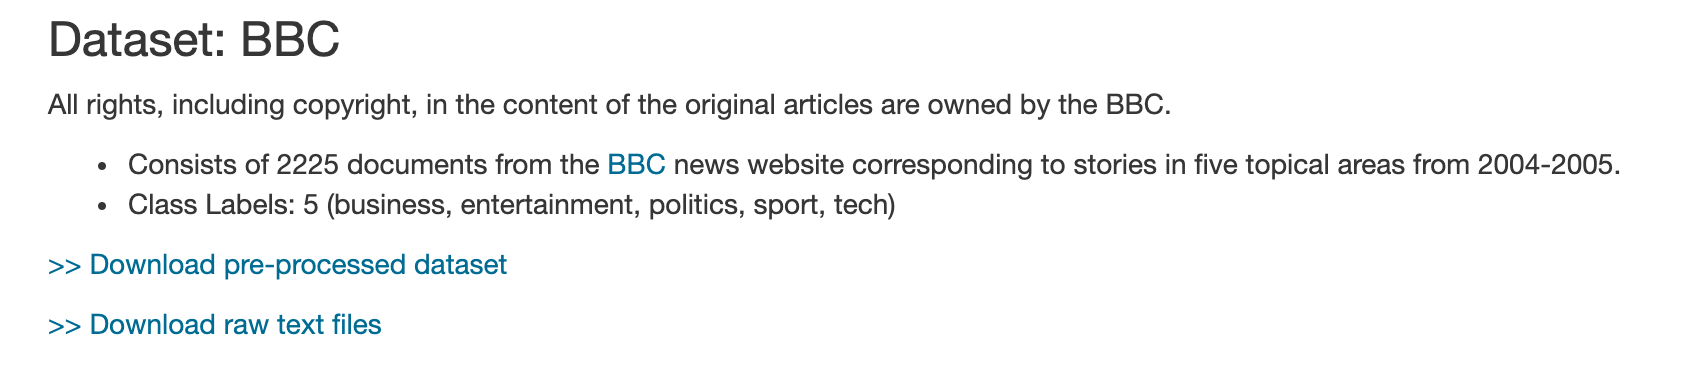

With the unzipped data in our Jupyter notebook directory, we can first get a list of all the text files using glob.

In [115]:
import glob

articles = glob.glob('bbc/**/*.txt')

articles_text = []
for article in news_articles:
    with open(article, encoding="utf8", errors='ignore') as f:
        data = f.read()
        articles_text.append(data)

In [116]:
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import re

tagged_data = []
for i, line in enumerate(articles_text):
    tokens = simple_preprocess(line)
    tagged_data.append(TaggedDocument(tokens, [i]))

In [144]:
# Generally it is better to use less epochs for larger datasets
# This is a small dataset so 30 works well. See article for recommendations

model = Doc2Vec(vector_size=50, min_count=2, epochs=30)

In [145]:
model.build_vocab(tagged_data)

In [146]:
# the %time command tells us how long a line of code takes to run
%time model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 42.1 s, sys: 1.9 s, total: 44 s
Wall time: 19.5 s


In [147]:
# this is a little trick - your computer will make a sound when it is done training
# and executes this line of code
import os
os.system("printf '\a'")

0

In [148]:
# Larger models can take a very long time to train
# Save the model now if it took more than a few minutes to run so you can reload the model later
model.save('./bbc.model')

In [149]:
# loading the model is easy! Now you don't need to retrain 
model = Doc2Vec.load("bbc.model")

In [150]:
features_extracted = []
for i, review in enumerate(articles_text):
    features_extracted.append(model.docvecs[i])

In [151]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
scaled = ss.fit_transform(features_extracted)

In [152]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(scaled)

In [153]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5, metric='cosine').fit(scaled)
_, closest = neighbors.kneighbors(kmeans.cluster_centers_)

In [154]:
for index, cluster_row in enumerate(closest):
    print('\n\nCluster number ' + str(index) + '\n\n')
    for col in cluster_row:
        print(articles_text[col])
        print('\n\n')



Cluster number 0


Rings of steel combat net attacks

Gambling is hugely popular, especially with tech-savvy criminals.

Many extortionists are targeting net-based betting firms and threatening to cripple their websites with deluges of data unless a ransom is paid. But now deep defences are being put in place by some of the UK's biggest net firms to stop these attacks. Increasing numbers of attacks and the huge amounts of data being used to try to bump a site off the web are prompting firms to adopt the measures. "Net firms are realising that it's not just about anti-virus and firewalls," said Paul King, chief security architect at Cisco. "There are more things that can be done in the network to protect data centres." Mr King said the only way to properly combat these so-called Distributed Denial-of-Service attacks was with intelligent net-based systems. Many of the gambling sites suffering DDoS attacks are in offshore data and hosting centres, so any large scale data flood could kno

In [155]:
import umap

In [156]:
%time embedding = umap.UMAP().fit_transform(scaled)

CPU times: user 4.9 s, sys: 154 ms, total: 5.05 s
Wall time: 4.69 s


In [157]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(embedding)
embedding_scaled = scaler.transform(embedding)

In [158]:
# Now we put all our data into one list
lookup = []

for index, umap_pos in enumerate(embedding_scaled):
    lookup.append({
        'filename': articles[index],
        'cluster_num': float(clusters[index]),
        'umap_pos': umap_pos.tolist(),
        'content': articles_text[index]
    })

In [159]:
# This is what one entry in the list looks like
lookup[0]

{'filename': 'bbc/entertainment/289.txt',
 'cluster_num': 2.0,
 'umap_pos': [0.6432263851165771, 0.44199854135513306],
 'content': 'Musicians to tackle US red tape\n\nMusicians\' groups are to tackle US visa regulations which are blamed for hindering British acts\' chances of succeeding across the Atlantic.\n\nA singer hoping to perform in the US can expect to pay $1,300 (£680) simply for obtaining a visa. Groups including the Musicians\' Union are calling for an end to the "raw deal" faced by British performers. US acts are not faced with comparable expense and bureaucracy when visiting the UK for promotional purposes.\n\nNigel McCune from the Musicians\' Union said British musicians are "disadvantaged" compared to their US counterparts. A sponsor has to make a petition on their behalf, which is a form amounting to nearly 30 pages, while musicians face tougher regulations than athletes and journalists. "If you make a mistake on your form, you risk a five-year ban and thus the ability 

In [160]:
# Finally, we use the JSON module to save this file 
# and save it in the public folder of our react app
import json

with open('lookup.json', 'w') as outfile:
    json.dump(lookup, outfile)